<a href="https://colab.research.google.com/github/nupursjsu/Machine-Learning/blob/master/Wildfire_cause_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Wildfire Cause Prediction**

##Team: FourReal

Member  |  Contribution 
---  |  --- |
Nupur Yadav  |   Initial data collection, preprocessing, EDA, Clustering (Kmeans, GMM), Random Forest
Chetan Kulkarni  |  Creation of  amalgamation script, Cross fold validation, Model comparision graphs
Lokesh Vadlamudi  |  Creation of  amalgamation script, Decision Tree, XGBoost
Ronak Mehta  |   Ran script to collect data for all the years, KNN, Naive Bayes

##**Business Case and Value**

The number of wildfire cases have drastically increased in the past few years, with more than 52,000 fires in 2018 alone. The goal of this project is to predict the cause of wildfire using meteorological and other weather related data such as location, day of the week, month, temperature and so on. This type of prediction can help government to monitor and mitigate impact of these fires by allocating proper resources based on the cause of fire.

##**Datasets:**

We have taken our base dataset from kaggle (https://www.kaggle.com/rtatman/188-million-us-wildfires) which had 1.88 million historic fires from throughout the United States and during the period of
1992-2015. It had features such as fire cause code (1-13) specifying what started the fire, fire cause description, latitude, and longitude, discovery date etc. 

In our dataset the fire cause code has values from 1-13 mapped to below fire cause description.

1 - Lightning

2 - Equipment Use

3 - Smoking

4 - Campfire

5 - Debris Burning

6 - Railroad

7 - Arson

8 - Children

9 - Miscellaneous

10 - Fireworks

11 - Powerline

12 - Structure

13 - Missing/Undefined

But it didn't have weather related data which was crucial for our prediction so we **amalgamated our base dataset with weather dataset from National Oceanic and Atmospheric Administration (ncdc.novaa.gov website)** and added fields such as Temperature, snow, precipitation, TOBS to our dataset.

##**Importing necessary libraries and loading our base dataset**



In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import random
random.seed(1)

In [0]:
#Importing Libraries
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import tree, preprocessing

import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
%matplotlib inline

import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import tree, preprocessing

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [122]:
link = 'https://drive.google.com/open?id=1ApRYxyMqnFKH8XW1GbQ-KZNJdbdeEdV9'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1ApRYxyMqnFKH8XW1GbQ-KZNJdbdeEdV9


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Fire.csv')

In [0]:
#Loading dataset into pandas dataframe
df = pd.read_csv('Fire.csv')

In [125]:
#Displaying first few records
df.head()

,Unnamed: 0,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,NaN,NaN,NaN,NaN,NaN,2005,2453403.5,33,1300.0,9.0,Miscellaneous,2453403.5,33.0,1730.0,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,63.0,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,13,13,AAC0,PIGEON,NaN,NaN,NaN,NaN,NaN,2004,2453137.5,133,845.0,1.0,Lightning,2453137.5,133.0,1530.0,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,61.0,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,27,021,A32W,SLACK,NaN,NaN,NaN,NaN,NaN,2004,2453156.5,152,1921.0,5.0,Debris Burning,2453156.5,152.0,2024.0,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,17.0,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,43,6,NaN,DEER,NaN,NaN,NaN,NaN,NaN,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1400.0,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,44,7,NaN,STEVENOT,NaN,NaN,NaN,NaN,NaN,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1200.0,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


##**Preprocessing data**

In [126]:
#Checking the columns in dataset
df.columns

Index(['Unnamed: 0', 'OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE',
       'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [127]:
#Displaying the shape of data
df.shape

(1880465, 40)

In [0]:
#Creating a new data frame with required columns
df = df[['FIRE_YEAR','STAT_CAUSE_CODE','STAT_CAUSE_DESCR','LATITUDE','LONGITUDE','STATE','DISCOVERY_DATE','FIRE_SIZE']].copy()

In [129]:
#Checking for the missing values in the dataset
df.isnull().sum()

FIRE_YEAR           0
STAT_CAUSE_CODE     0
STAT_CAUSE_DESCR    0
LATITUDE            0
LONGITUDE           0
STATE               0
DISCOVERY_DATE      0
FIRE_SIZE           0
dtype: int64

As we can see our dataset don't have any missing values.

In [130]:
#Displaying top 5 records
df.head()

,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE
0,2005,9.0,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10
1,2004,1.0,Lightning,38.933056,-120.404444,CA,2453137.5,0.25
2,2004,5.0,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10
3,2004,1.0,Lightning,38.559167,-119.913333,CA,2453184.5,0.10
4,2004,1.0,Lightning,38.559167,-119.933056,CA,2453184.5,0.10


In [131]:
#Converting the DISCOVERY_DATE field's Julian Date format in Gregorian dates
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df.head() #check the data

,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE
0,2005,9.0,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10,2005-02-02
1,2004,1.0,Lightning,38.933056,-120.404444,CA,2453137.5,0.25,2004-05-12
2,2004,5.0,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10,2004-05-31
3,2004,1.0,Lightning,38.559167,-119.913333,CA,2453184.5,0.10,2004-06-28
4,2004,1.0,Lightning,38.559167,-119.933056,CA,2453184.5,0.10,2004-06-28


In [132]:
#Getting some additional data fields such as month and day of the week.
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY_OF_WEEK'] = df['DATE'].dt.dayofweek
df.head()

,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE,MONTH,DAY_OF_WEEK
0,2005,9.0,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10,2005-02-02,2,2
1,2004,1.0,Lightning,38.933056,-120.404444,CA,2453137.5,0.25,2004-05-12,5,2
2,2004,5.0,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10,2004-05-31,5,0
3,2004,1.0,Lightning,38.559167,-119.913333,CA,2453184.5,0.10,2004-06-28,6,0
4,2004,1.0,Lightning,38.559167,-119.933056,CA,2453184.5,0.10,2004-06-28,6,0


Day_OF_Week with Monday=0, Sunday=6.

In [0]:
df_orig=df[['FIRE_YEAR', 'STAT_CAUSE_DESCR', 'LATITUDE',	'LONGITUDE',	'STATE', 'DISCOVERY_DATE', 'FIRE_SIZE',	'MONTH', 'DAY_OF_WEEK']]

##**Exploratory data analysis**

Doing some exploratory data analysis to see how the features are correlated, what are relevant features for our prediction and if any hidden information we can get to facilitate our prediction.

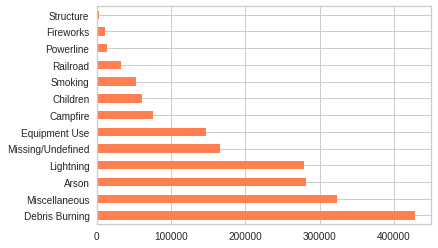

In [134]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral')
plt.show()

Our dataset has around 13 causes which are too many classes. May be we will try to club these causes to reduce the number of classes and see if this improves our model accuracy.

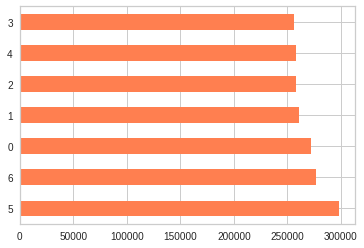

In [135]:
df['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

The above graph shows that on weekends (5&6) the fires discovered are slightly more. We are assuming that is because of the people being careless on weekends with campfires or smoking or probably because of some malicious intent. Now, we would like to see how fires are distributed across the weekdays because of the natural causes such as lightning.

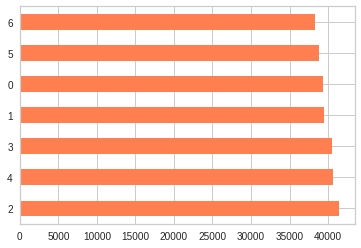

In [136]:
df_lightning = df[df['STAT_CAUSE_DESCR']=='Lightning']
df_lightning['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

As we can see the fires are more on weekdays now and lowered on weekends. I am imagining if the increase on weekends is due to malicious fires such as - Arson. So now we will check the fire distribution on weekdays because of Arson.

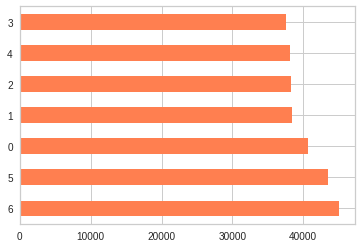

In [137]:
df_arson = df[df['STAT_CAUSE_DESCR']=='Arson']
df_arson['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

The above graph makes it significant that the increase in fire on weekends is because of Arson. We can see probably a 30% increase on weekends than the average of weekdays.

This also proves that Day_Of_Week is an important feature to be kept in our feature set.

##**Clustering**

###**Performing K-Means Clustering as part of EDA**

We tried clustering based on some selected features to see if we can gain any other insights from our dataset.

In [0]:
#K-means clustering on fire cause and fire size
data = df[['FIRE_SIZE','STAT_CAUSE_CODE']]

####**Using Elbow method to find optimal k**

In [0]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data)
    Sum_of_squared_distances.append(km.inertia_)

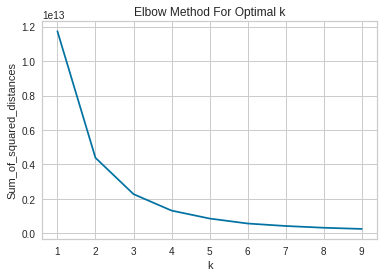

In [140]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We got optimal k as 3.

####**Silhouette score analysis**

In [0]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(3,20), metric='silhouette', timings=False)

visualizer.fit(data)    
visualizer.poof() 

From Silhouette score analysis we got that 3 clusters are optimal. Silhoutte score = 0.86

In [0]:
#Applying K-means for optimal k=3
kmeans = KMeans(n_clusters=3)
y = kmeans.fit_predict(data)

In [143]:
#Adding cluster column to dataset for further analysis
df['cluster'] = y
df.head()

,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE,MONTH,DAY_OF_WEEK,cluster
0,2005,9.0,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10,2005-02-02,2,2,0
1,2004,1.0,Lightning,38.933056,-120.404444,CA,2453137.5,0.25,2004-05-12,5,2,0
2,2004,5.0,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10,2004-05-31,5,0,0
3,2004,1.0,Lightning,38.559167,-119.913333,CA,2453184.5,0.10,2004-06-28,6,0,0
4,2004,1.0,Lightning,38.559167,-119.933056,CA,2453184.5,0.10,2004-06-28,6,0,0


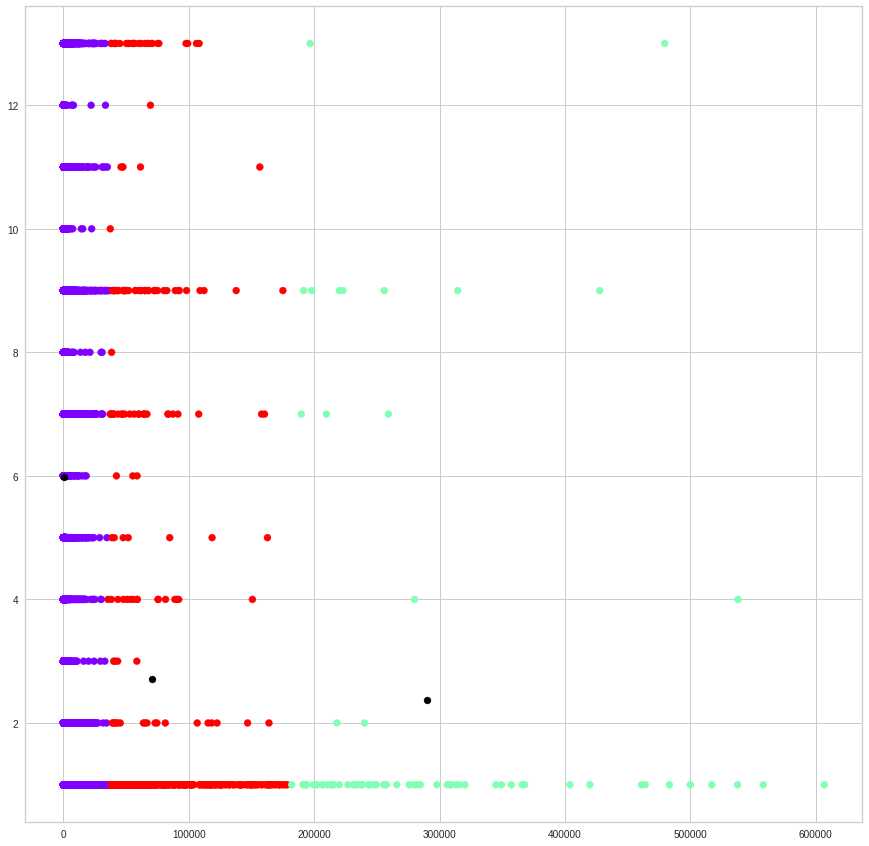

In [51]:
#Plotting the clusters obtained
plt.figure(1,figsize=(15,15))
plt.scatter(df.FIRE_SIZE, df.STAT_CAUSE_CODE, c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')

As we can see, the above clusters didn't obtain any meaningful information.

###**GMM clustering**

**Performing GMM clustering on latitude and longitude to see the geographical coverage of the data**

In [0]:
gmm1=GaussianMixture(n_components=4, covariance_type="spherical").fit(df[['LATITUDE','LONGITUDE']])
labels1 = gmm1.predict(df[['LATITUDE','LONGITUDE']])

Text(0, 0.5, 'LONGITUDE')

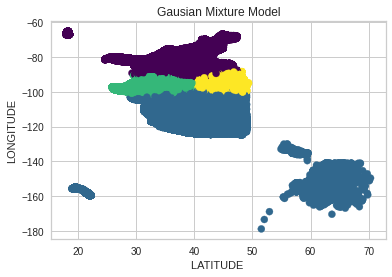

In [53]:
plt.scatter(df['LATITUDE'],df['LONGITUDE'], c=labels1, s=50, cmap='viridis')
plt.title('Gausian Mixture Model')
plt.xlabel('LATITUDE ')
plt.ylabel('LONGITUDE')

The above plot clearly shows the map of United States and most of the fires have occurred in longitutes between -100 and -120 which is majorly California region.

##**Data Narrative**



1.   On weekends, the fires discovered are slightly more. We are assuming that is because of the people being careless on weekends with campfires or smoking or probably because of some malicious intent.
2.   In case of Lightning, fires are more on weekdays and lowered on weekends. We are imagining if the increase on weekends is due to malicious fires such as - Arson. So we checked the fire distribution on weekdays because of Arson.
3.   The histogram showed that the increase in fire on weekends is because of Arson. We can see probably a 30% increase on weekends than the average of weekdays. This also proves that Day_Of_Week is an important feature to be kept in our feature set.
4.    The cluster plot clearly shows the map of United States and most of the fires have occurred in longitutes between -100 and -120 which is majorly California region.
5.    We have 13 categories in our target variable and may be reducing these can improve accuracy, which we tried later on.




###**Correlation matrix**

Plotting correlation matrix to get a better understanding of how the features are correlated.

In [144]:
#First converting all features to numeric
le = preprocessing.LabelEncoder()
df['STAT_CAUSE_DESCR'] = le.fit_transform(df['STAT_CAUSE_DESCR'])
df['STATE'] = le.fit_transform(df['STATE'])
df = df.drop(['cluster'], axis=1)
df.head()

,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE,MONTH,DAY_OF_WEEK
0,2005,9.0,7,40.036944,-121.005833,4,2453403.5,0.10,2005-02-02,2,2
1,2004,1.0,6,38.933056,-120.404444,4,2453137.5,0.25,2004-05-12,5,2
2,2004,5.0,3,38.984167,-120.735556,4,2453156.5,0.10,2004-05-31,5,0
3,2004,1.0,6,38.559167,-119.913333,4,2453184.5,0.10,2004-06-28,6,0
4,2004,1.0,6,38.559167,-119.933056,4,2453184.5,0.10,2004-06-28,6,0


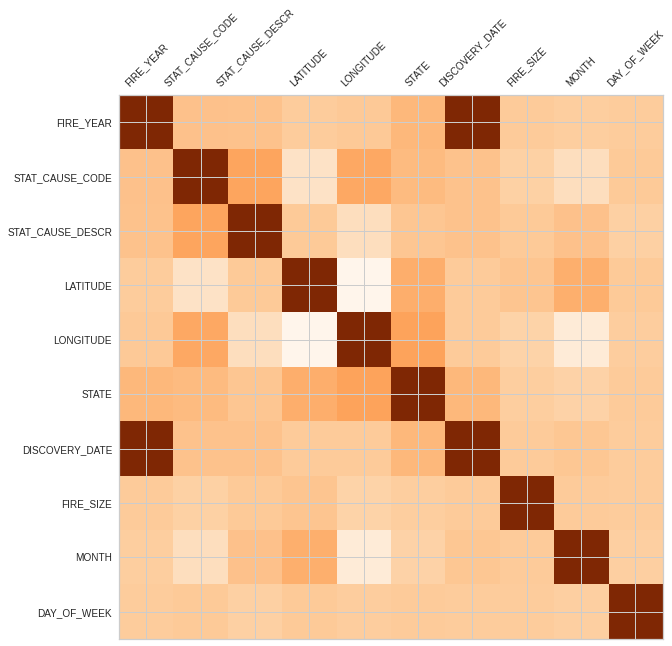

In [55]:
def plot_corr(df,size=10):
    corr = df.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Oranges)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()
    

    
plot_corr(df)

In the above plot darker shades means strong correlation wheras white shade means no correlation. We can see that month is strongly correlated to latitude wheras weakly correlated to longitide.

##**Predictive Modeling**

We ran below six algorithms to see which is performing best for our prediction.

In [0]:
#Defining algorithms to apply to our dataset
models_dict={}
models_dict['LogisticRegression']        = LogisticRegression()
models_dict['Dtree']     = DecisionTreeClassifier()
models_dict['NB']        = GaussianNB()
models_dict['KNN']       = KNeighborsClassifier()
models_dict['RForest']   = RandomForestClassifier(n_estimators=50)
models_dict['XGB']       = XGBClassifier()

In [0]:
#function to compare the different algorithms based on recall of model 
def compareAlgos(model_results):
  fig = plt.figure(figsize=(11,6))
  fig.suptitle('Algorithm Comparison')
  ax = fig.add_subplot(111)
  plt.boxplot([modelresult for name,modelresult in model_results.items()])
  ax.set_xticklabels([name for name,modelresult in model_results.items()])
  plt.show()

#writing a functional api layer which takes models , trains and tests and plots comparision of those models on a graph 
def fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test):
  accuracy={}
  specificity={}
  sensitivity={}
  #models_dict holds name and its function , like {'LR':LogsticRegression()}
  for name,model in models_dict.items():
    try:
      #fitting model on the train data
      model.fit(X_train,y_train)
      #predicting model on X_test 
      y_pred=model.predict(X_test)
      print('*'*100)
      print('Model:',name)
      #printing Confusion matrix an dAccuracy of each model
      print("Confusion Matrix: ",confusion_matrix(y_test, y_pred)) 
      print("Accuracy : ",accuracy_score(y_test,y_pred)*100)

      #mainitaing a dictionary of results of accuracy of each model to use it to plot in one systyem
      accuracy[name]=accuracy_score(y_test,y_pred)*100
      cm=confusion_matrix(y_test, y_pred)
      sensitivity[name] = (cm[0,0]/(cm[0,0]+cm[0,1]))*100
      specificity[name] = (cm[1,1]/(cm[1,0]+cm[1,1]))*100
      print("Classificarion Report : ")
      print(classification_report(y_test, y_pred))
    except ValueError:
      print(name,'failed')
  
  #converting dictionaries to dataframes to have them handy
  accuracy=pd.DataFrame.from_dict(accuracy,orient='index').reset_index()
  sensitivity=pd.DataFrame.from_dict(sensitivity,orient='index').reset_index()
  specificity=pd.DataFrame.from_dict(specificity,orient='index').reset_index()
  # print(accuracy)
  accuracy.columns=['model_name','accuracy']
  sensitivity.columns=['model_name','sensitivity']
  specificity.columns=['model_name','specificity']
  
  #plotting accuracy,sensitivity,specificity of each model
  plt.figure(figsize=(16, 6))
  ax = sns.lineplot(data=accuracy, x='model_name', y='accuracy',legend='full')
  ax = sns.lineplot(data=sensitivity, x='model_name', y='sensitivity',legend='full')
  ax = sns.lineplot(data=specificity, x='model_name', y='specificity',legend='full')
  ax = sns.barplot(data=accuracy, x='model_name', y='accuracy')
  plt.title('Blue :Accuracy,Orange: Senstivity,Green : Specicificity ')

In [0]:
#Dropping 'DATE' and 'STAT_CAUSE_CODE' variable to create our final feature set
df = df.drop('DATE',axis=1)
df = df.drop('STAT_CAUSE_CODE', axis=1)
df = df.dropna()

In [0]:
#Splitting dataset into feature set and target variable, X and Y respectively
X = df.drop(['STAT_CAUSE_DESCR'], axis=1).values
Y = df['STAT_CAUSE_DESCR'].values

####**Applying our already defined six algorithms on base dataset with 13 classes in target variable**

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix:  [[     0      0      0 112595      0      0      0      0      0      0
       0      0      0]
 [     0      0      0  30343      0      0      0      0      0      0
       0      0      0]
 [     0      0      0  24468      0      0      0      0      0      0
       0      0      0]
 [     0      0      0 171639      0      0      0      0      0      0
       0      0      0]
 [     0      0      0  59223      0      0      0      0      0      0
       0      0      0]
 [     0      0      0   4562      0      0      0      0      0      0
       0      0      0]
 [     0      0      0 111672      0      0      0      0      0      0
       0      0      0]
 [     0      0      0 129458      0      0      0      0      0      0
       0      0      0]
 [     0      0      0  66484      0      0      0      0      0      0
       0      

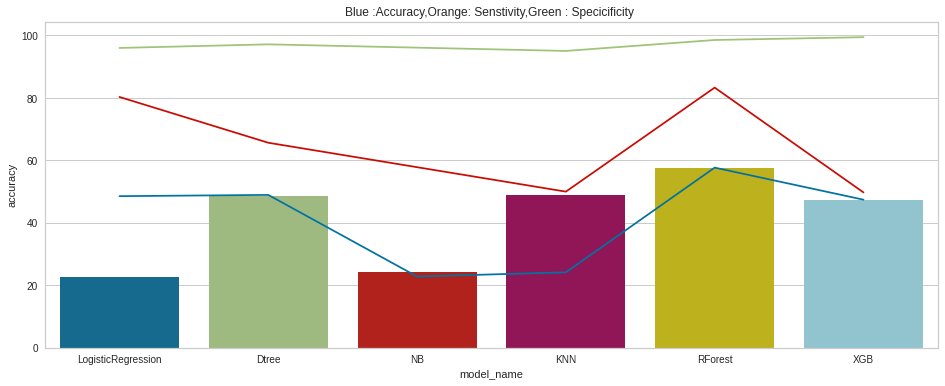

In [60]:
#Splitting dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=1)

#Training and evaluating our set of defined models
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

As we can see above `Random Forest` model perfomed the best among all on our base dataset with an accuracy of `58%`. Also, it has a high sensitivity and specificity.

###**Data Enrichment**

Importing amalgamated fire dataset which contains weather related columns such as Temperature, Precipitation, Snow etc. The weatherDataLoadFinal.ipynb file contains the script to fetch data from National Oceanic and Atmospheric Administration (ncdc.novaa.gov website), which has also been shared on the drive.

####**Importing and loading amalgamated data**

In [146]:
#Importing amalgamated dataset
link = 'https://drive.google.com/open?id=1qnqDNrDyxVPBTxE-6BTYDVz-7Iennl_m'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1qnqDNrDyxVPBTxE-6BTYDVz-7Iennl_m


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('AmalgamatedFireDataset.csv')

In [0]:
#Loading dataset as pandas data frame
amal_df = pd.read_csv('AmalgamatedFireDataset.csv')
amal_df=amal_df[['FIRE_YEAR', 'STAT_CAUSE_DESCR', 'LATITUDE', 'LONGITUDE', 'STATE', 'DISCOVERY_DATE', 'FIRE_SIZE_x', 'discovery_month', 'discovery_weekday', 'TMAX', 'PRCP', 'TOBS', 'SNOW']]

#Keeping a copy of original amalgamanted feature set.
amal_df_orig=amal_df[['FIRE_YEAR', 'STAT_CAUSE_DESCR', 'LATITUDE', 'LONGITUDE', 'STATE', 'DISCOVERY_DATE', 'FIRE_SIZE_x', 'discovery_month', 'discovery_weekday', 'TMAX', 'PRCP', 'TOBS', 'SNOW']]

#Converting categorical variables into numeric
amal_df['STAT_CAUSE_DESCR'] = le.fit_transform(amal_df['STAT_CAUSE_DESCR'])
amal_df['STATE'] = le.fit_transform(amal_df['STATE'])
amal_df['discovery_month'] = le.fit_transform(amal_df['discovery_month'])
amal_df['discovery_weekday'] = le.fit_transform(amal_df['discovery_weekday'])

In [0]:
#Splitting dataset into feature set and target variable, X and Y respectively
X = amal_df.drop(['STAT_CAUSE_DESCR'], axis=1).values
Y = amal_df['STAT_CAUSE_DESCR']

####**Applying our already defined six algorithms on amalgamanted dataset with 13 classes in target variable**

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix:  [[    0     0     0     0     0     0 16994     0     0     0     0     0
      0]
 [    0     0     0     0     0     0  8586     0     0     0     0     0
      0]
 [    0     0     0     0     0     0  4012     0     0     0     0     0
      0]
 [    0     0     0     0     0     0 21707     0     0     0     0     0
      0]
 [    0     0     0     0     0     0  8545     0     0     0     0     0
      0]
 [    0     0     0     0     0     0  1351     0     0     0     0     0
      0]
 [    0     0     0     0     0     0 26415     0     0     0     0     0
      0]
 [    0     0     0     0     0     0 22352     0     0     0     0     0
      0]
 [    0     0     0     0     0     0  6259     0     0     0     0     0
      0]
 [    0     0     0     0     0     0  1466     0     0     0     0     0
      0]
 [    0     0     0     

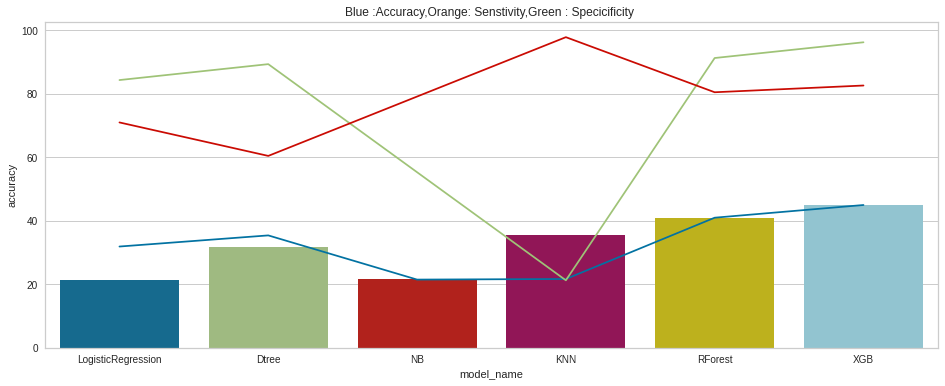

In [65]:
#Training and evaluating our set of defined models
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

#Training and evaluating our set of defined models on Amalgamated dataset
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

As we can see on our amalgamated dataset we got the maximum accuracy of 45% by `XGBoost` algorithm. 
We thought of reducing the number of labels in our target variable to 3 to see if this improves our accuracy.

####**Reducing target column categories from 13 to 3 and applying the same set of algorithms to improve accuracy.**

In [0]:
#Method to club 13 categories in target variable 'STAT_CAUSE_DESCR' to 3 categories as natural, human_caused, and other.
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    human_caused = ['Arson','Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in human_caused:
        cause = 2
    else:
        cause = 3
    return cause

In [0]:
#Again creating feature set X and Y
X = amal_df.drop(['STAT_CAUSE_DESCR'], axis=1).values
Y = amal_df_orig['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))

Here, we also thought of reducing the number of columns to reduce the complexity of our models so we applied PCA to capture 99.9% variance and came up with 3 new features.

####**Further applying PCA to reduce model complexity by reducing the number of columns.**

In [152]:
#Applying PCA
pca = PCA(n_components=0.999)
pca.fit(X)
x = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", x.shape)

original shape:    (615282, 12)
transformed shape: (615282, 3)


12 columns in our original dataset were converted to 3 columns using PCA.

In [0]:
#Splitting pca feature set into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

####**Skearn provides default scorer, which considers many scoring metric like accuracy, recall, specificity, sensitivity etc. And the Scorer each fold of dataset.**

This provides clearer understanding of how each model is performing.
We want to have a system with better scores and less outliers is the learning.


LogisticRegression: 0.555112 (0.003558)
Dtree: 0.616117 (0.001784)
NB: 0.557930 (0.003643)
KNN: 0.637838 (0.001970)
RForest: 0.682160 (0.002562)
XGB: 0.679592 (0.002366)


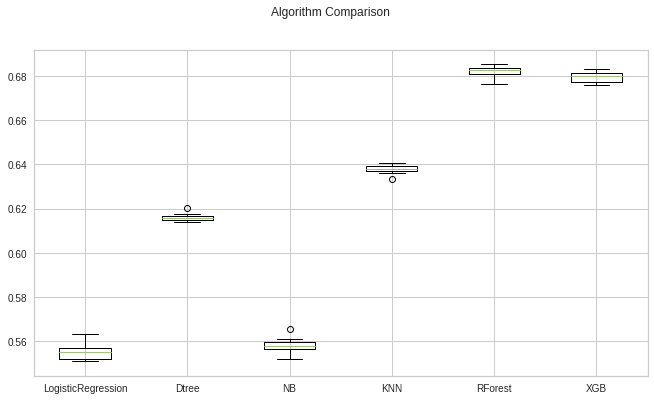

In [154]:
#Performing k-fold cross validation test on all the models
model_results={}
scoring = 'recall'
seed=1

#performing K Folds on testing the recall of each model, Printing recall mean and standard deviation 
kfold = KFold(n_splits=10, random_state=seed)
for name, model in models_dict.items():
    model_results[name]=cross_val_score(model, X_train, y_train, cv=kfold, scoring=None)
    msg = "%s: %f (%f)" % (name, model_results[name].mean(), model_results[name].std())
    print(msg)

compareAlgos(model_results)

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix:  [[  133 26282     0]
 [   44 67987     0]
 [   35 28576     0]]
Accuracy :  55.356460827096384
Classificarion Report : 
              precision    recall  f1-score   support

           1       0.63      0.01      0.01     26415
           2       0.55      1.00      0.71     68031
           3       0.00      0.00      0.00     28611

    accuracy                           0.55    123057
   macro avg       0.39      0.33      0.24    123057
weighted avg       0.44      0.55      0.40    123057

****************************************************************************************************
Model: Dtree
Confusion Matrix:  [[16945  6390  3080]
 [ 6746 49083 12202]
 [ 3497 15246  9868]]
Accuracy :  61.675483718927005
Classificarion Report : 
              precision    recall  f1-score   support

           1       0.62      0.64      0.63  

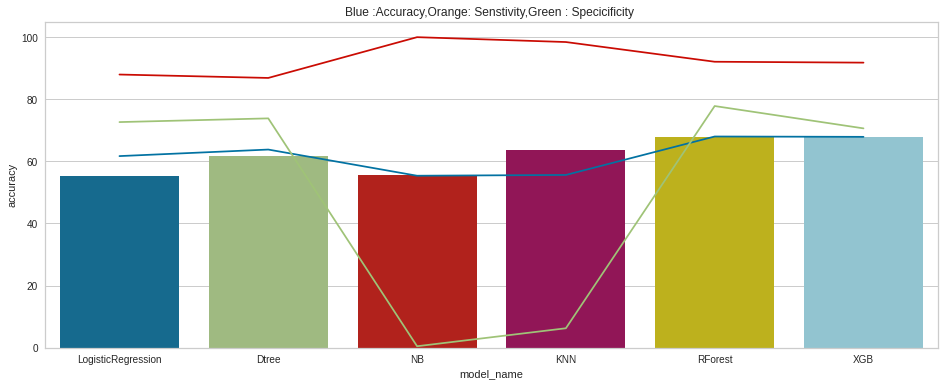

In [81]:
##Training and evaluating our set of defined models on Amalgamated dataset with PCA applied
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

##**Comparision and Result**

Reducing the number of target variable categories from 13 to 3 ('Natural', Human_caused' and 'Other' and also reducing the number of columns using PCA significantly increased our models accuracy. Among all `RForest` and `XGBoost` are giving approx same accuracy of `68%`. But `RForest` is comparitively a better performer since it has better Specificity.

##**Conclusion**



1.   As the training data was incomplete without weather data supporting it, the amalgamated data was made possible with the help of latitude, longitude and date columns.
2.   We observed a significant increase in accuracy of our models after reducing target variable categories from 13 to 3 (Natural, human_caused and other) and also, reducing number of columns using PCA to reduce the complexity of our models.
3.   Finally, we were able to hit the maximum accuracy of approx. `68%` on our amalgamated dataset with `RForest` algorithm.